In [1]:
import networkx as nx

## Basics of NetworkX

One way to create a graph is from a list of edges.

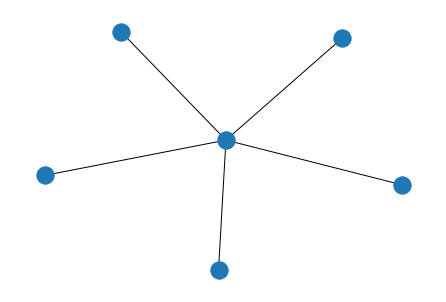

In [2]:
star = nx.Graph( [(1,2),(1,3),(1,4),(1,5),(1,6)] )
nx.draw(star)

Another way to create a graph is to give the start and end nodes of the edges as columns in a data frame.

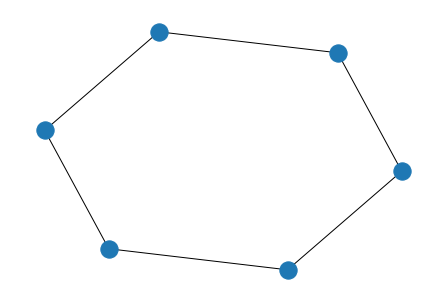

In [3]:
import pandas as pd
df = pd.DataFrame( {'from':[1,2,3,4,5,6],'to':[2,3,4,5,6,1]} )
H = nx.from_pandas_edgelist(df,'from','to')
nx.draw(H)

There are functions that generate different well-studied types of graphs. A **complete graph** is one that has every possible edge.

5 nodes, 10 edges


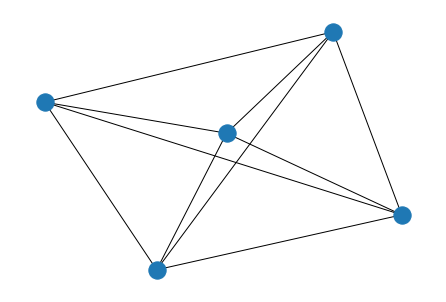

In [136]:
K5 = nx.complete_graph(5)
print("5 nodes,",nx.number_of_edges(K5),"edges")
nx.draw(K5)


A **lollipop graph** connects a complete subgraph to a line of nodes.

9 nodes, 18 edges


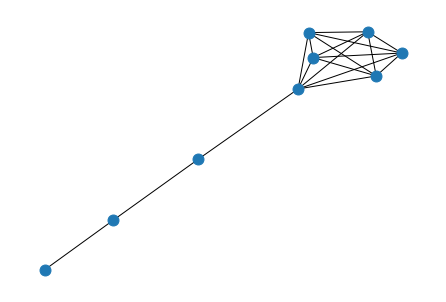

In [125]:
G = nx.lollipop_graph(6,3)
print(G.number_of_nodes(),"nodes,",G.number_of_edges(),"edges")
nx.draw(G,node_size=120)

An **Erdős-Rényi graph** includes each individual possible edge with a fixed probability $p$. It is the most commonly considered type of random graph.

60 nodes, 145 edges


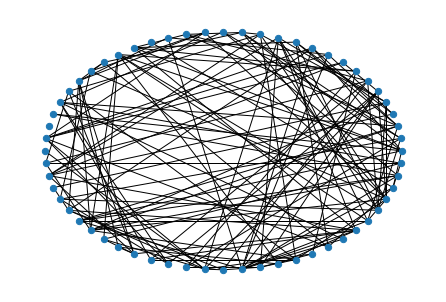

In [130]:
er = nx.erdos_renyi_graph(60,.08,seed=1)
print(er.number_of_nodes(),"nodes,",er.number_of_edges(),"edges")
nx.draw_circular(er,node_size=40)

A **Watts–Strogatz graph** is randomized but prefers links to a small group of neighbors over distant nodes.

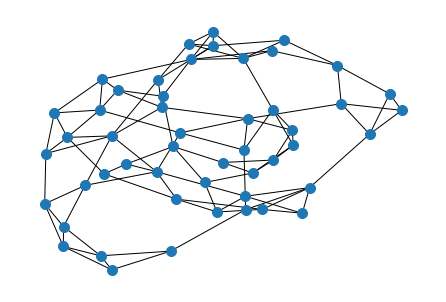

In [135]:
H = nx.watts_strogatz_graph(50,5,.2,seed=4)
nx.draw(H,node_size=100)

There are different ways to draw a particular graph in the plane, as determined by the positions of the nodes. The default is to imagine that the edges are springs pulling on the nodes. But there are alternatives that may be useful at times.

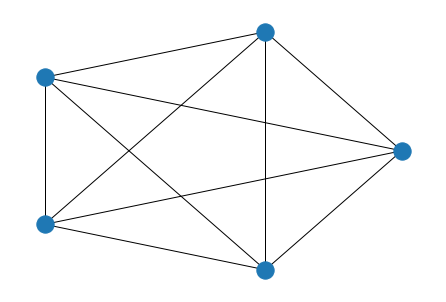

In [137]:
nx.draw_circular(K5)

There are many ways to read graphs from (and write them to) files. Here is a friend network among Twitch users. The file has a pair of nodes representing one edge on each line.

In [8]:
twitch = nx.read_edgelist("musae_edges.csv",delimiter=',',nodetype=int)

In [9]:
twitch.number_of_nodes(),twitch.number_of_edges()

(7126, 35324)

## Ego graphs

We can extract for any node of a graph its **ego graph**, which is the subset of nodes it is connected to, along with the associated edges.

In [10]:
ego = nx.ego_graph(twitch,400)

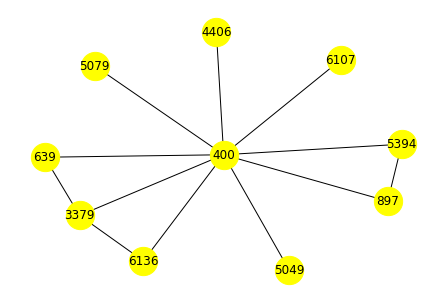

In [11]:
nx.draw(ego,with_labels=True,node_size=800,node_color="yellow")

Notice that the nodes of the ego network have the same labels as they did in the original graph that it was taken from.

We can widen the ego graph to include the ego graphs of all the neighbors:

In [12]:
big_ego = nx.ego_graph(twitch,400,radius=2)
big_ego.number_of_nodes()

528

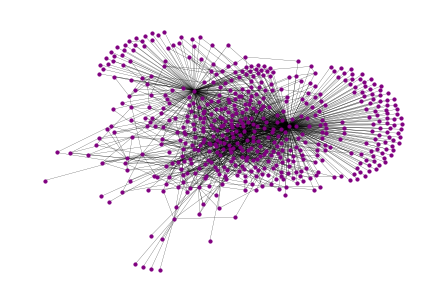

In [77]:
pos = nx.spring_layout(big_ego,iterations=100)
nx.draw(big_ego,pos=pos,width=0.2,node_size=10,node_color="purple")

## Adjacency and degree

Every graph can be associated with an **adjacency matrix**. Suppose the nodes are numbered from $0$ to $n-1$. The adjacency matrix is $n\times n$ and has a 1 at position $(i,j)$ if there is an edge between node $i$ and node $j$, and a 0 otherwise.

In [15]:
A = nx.adjacency_matrix(ego)
A

<10x10 sparse matrix of type '<class 'numpy.int64'>'
	with 24 stored elements in Compressed Sparse Row format>

Observe that `A` is not stored in the format we have gotten used to. In a large network we would expect most of its entries to be zero, so it makes more sense to store it as a *sparse matrix*, where we keep track of only the nonzero entries:

In [16]:
print(A[:3,:])

  (0, 1)	1
  (0, 2)	1
  (1, 0)	1
  (1, 2)	1
  (1, 3)	1
  (1, 4)	1
  (1, 5)	1
  (1, 6)	1
  (1, 7)	1
  (1, 8)	1
  (1, 9)	1
  (2, 0)	1
  (2, 1)	1


We can easily convert `A` to a standard array, if it is not too large to fit in memory.

In [17]:
A.toarray()

array([[0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0]])

In an undirected graph, we have $A_{ij}=A_{ji}$ everywhere, and we say that $A$ is *symmetric*. 

The **degree** of a node is the number of edges that have the node as an endpoint. Given adjacency matrix $A$, we can get the degrees of the nodes by summing down the rows (or across columns):

In [76]:
np.asarray(np.sum(A,axis=0)).flatten()

array([2, 9, 2, 3, 1, 1, 2, 1, 1, 2])

There is a built-in way to find the degrees directly:

In [83]:
deg = pd.DataFrame(twitch.degree,columns=["node","degree"])
deg

,node,degree
0,6194,6
1,255,6
2,980,18
3,2992,4
4,2507,22
...,...,...
7121,2933,1
7122,2267,1
7123,6694,1
7124,6995,1


We can now find how many nodes in the network are connected to it by just one edge:

In [84]:
sum(deg.degree==1)

1161

Here's a histogram of the degree distribution.

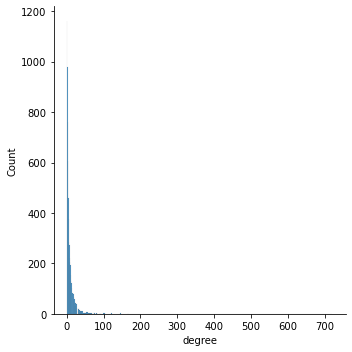

In [114]:
import seaborn as sns
hist = sns.displot(data=deg,x="degree")

We'll revisit this degree distribution in the next section.

## Connectedness

We say that two nodes in a network are **connected** if there is a path of edges between them. If every pair of nodes in the network are connected, then we say the *graph* is connected.

In [18]:
nx.is_connected(twitch)

True

If a subset $C$ of nodes (with associated edges) forms a connected graph, and there are no links from nodes in $C$ to nodes outside of $C$, then $C$ is a **connected component**. A connected graph has one connected component; the other extreme is a graph with no edges, in which the number of connected components equals the number of nodes. 

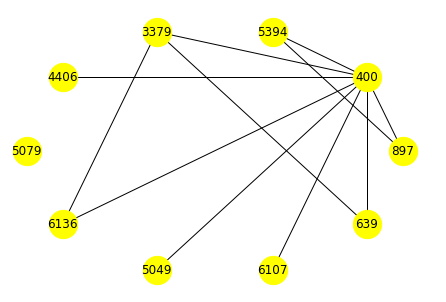

In [19]:
ego.remove_edge(400,5079)
nx.draw_circular(ego,with_labels=True,node_size=800,node_color="yellow")

In [20]:
nx.number_connected_components(ego)

2

An **articulation node** is a node that, when removed (with its incident edges) from a graph, increases the number of connected components. Each articulation node is a "choke point" or hub for communication between otherwise disconnected subgraphs. The Twitch network has many such nodes.

In [117]:
ap = list(nx.articulation_points(twitch))
len(ap)

780

Removing an articulation node results in at least two connected components, but there might be more.

In [122]:
t2 = twitch.copy()
t2.remove_node(ap[0])
nx.number_connected_components(t2)

13

In [120]:
twitch.copy().remove_node(ap[0])

array([[<AxesSubplot:xlabel='degree', ylabel='Count'>]], dtype=object)

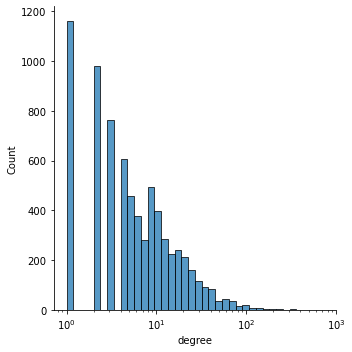

In [38]:
import seaborn as sns
hist = sns.displot(data=pd.DataFrame((twitch.degree),columns=["node","degree"]),x="degree",log_scale=True)
hist.axes

In [220]:
import numpy as np
sum(np.array(s)==2)

1222

In [221]:
len(s)

1231

In [111]:
ct

,degree,number
0,0.000000,7.057037
1,0.693147,6.886532
2,1.098612,6.634633
3,1.386294,6.405228
4,1.609438,6.126869
...,...,...
125,5.017280,0.000000
126,4.663439,0.000000
127,4.744932,0.000000
128,5.442418,0.000000


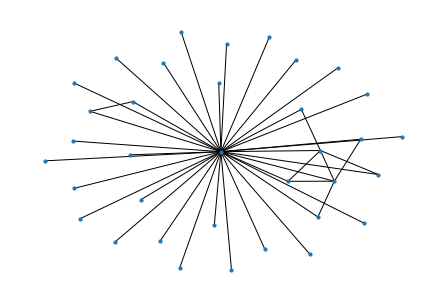

In [228]:
nx.draw(nx.ego_graph(twitch,987),node_size=10)

In [229]:
{1,2,3} - {1}

{2, 3}

In [244]:
cc = nx.connected_components(twitch.subgraph(twitch.nodes - {987}))
[len(g) for g in cc]

[7121, 2, 1, 1]

In [239]:
twitch.size()

35324

In [248]:
len(list(nx.bridges(twitch)))

1222